In [163]:
import pandas as pd
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import KBinsDiscretizer, StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from plsr.analysis import *

In [164]:
from curvefit import DatasetSpectra

In [165]:
from boxsers.preprocessing import rubberband_baseline_cor

In [166]:
file_path = '~/data/dataset_565.csv'
domain_path = '~/data/dataset_565_domain.csv'

<Axes: >

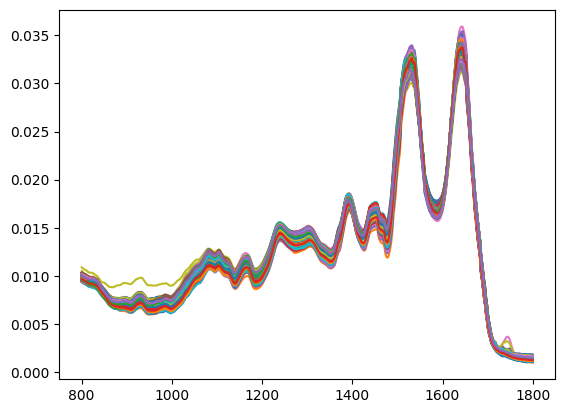

In [271]:
dataset = DatasetSpectra(file_path, domain_path)
dataset.select_max_abs(0.3)
# dataset.baseline_corr()
dataset.savgol_filter(window_length=5, polyorder=2, deriv=0)
dataset.normalization(kind='vector')
dataset.select_region(800, 1800)
pd.DataFrame(dataset.spectra, columns=dataset.wavenumbers).T.plot(legend=False)

In [272]:
X = dataset.spectra
y = dataset.hba1c
# scaler = StandardScaler()
# y = scaler.fit_transform(y.reshape(-1, 1)).ravel()

<Axes: ylabel='Count'>

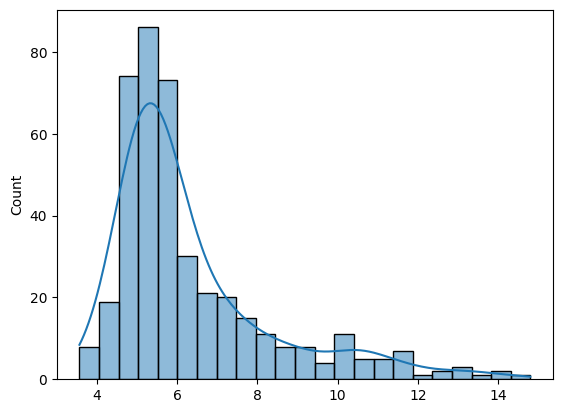

In [273]:
sns.histplot(y, kde=True)

In [274]:
discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform', subsample=None, random_state=4)
categories = discretizer.fit_transform(y.reshape(-1, 1))

In [275]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=categories, random_state=44)

Text(0.5, 0, 'HbA1c')

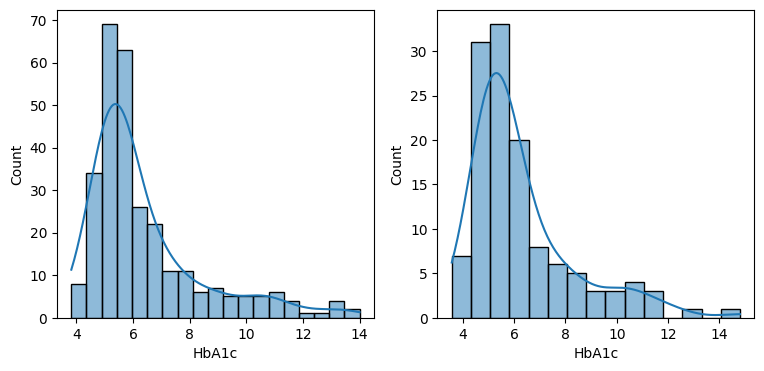

In [276]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4))
sns.histplot(y_train, ax=axs[0], kde=True)
sns.histplot(y_test, ax=axs[1], kde=True)

axs[0].set_xlabel('HbA1c')
axs[1].set_xlabel('HbA1c')

┌───────────────────────────┐
│        FIT RESULTS        │
├───────────────────────────┤
│ RMSE = 1.5248             │
│ R2 = 0.4354               │
│ R = 0.6744                │
│ Number of components = 14 │
└───────────────────────────┘


(<Figure size 1000x800 with 4 Axes>,
 array([[<Axes: xlabel='Num of components', ylabel='$R^2$'>,
         <Axes: xlabel='Num of components', ylabel='RMSE'>],
        [<Axes: xlabel='y true', ylabel='y predicted'>,
         <Axes: xlabel='y predicted', ylabel='Residuals'>]], dtype=object))

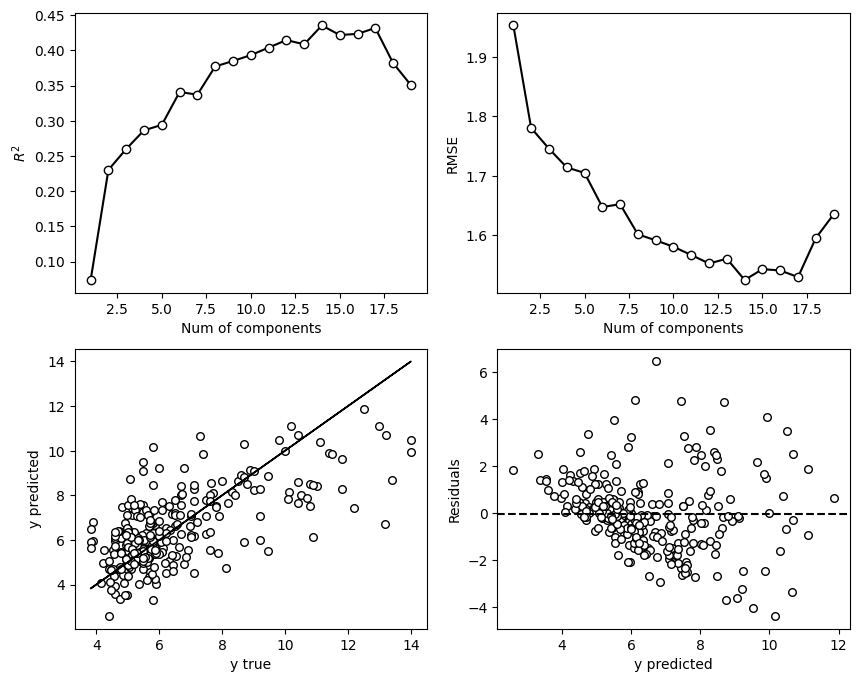

In [277]:
plot_number_components(X_train, y_train, number_range=(1, 20), cv=5)